# EEP 153 Project 2: Group Atwater

### Minimum Cost Diet:

**Topic:**
Cost comparison of a minimized vegetarian diet for Berkeley residents across 5 different local grocery stores (shopping at one among Safeway, Trader Joe's, Amazon Fresh, Berkeley Bowl, Sprout's)

**Objectives:**

1. Explore different grocery store options to maintain a cost-minimized vegetarian diet in the city of Berkeley using a linear programming model based on the Stigler Diet Problem.
2. Create and evaluate vegetarian recipes that meet the minimum nutrient requirements for different sex and age groups
3. Utilize multiple data visualizations to compare and contrast the cost efficiency of a vegetarian diet across 5 different grocery stores in Berkeley

## Table of contents
1. [[A] Description of Population of Interest](#pop)
2. [[A] Dietary Reference Intakes](#dietre)
3. [[A] Google Sheet on Prices for Different Foods](#google)
4. [[A] Nutritional Content of Different Foods](#nutr)
5. [[A] Solution to the Minimum-Cost-Diet  Problem](#sol)
6. [[B] Is our solution edible?](#edi)
7. [[B] Meal Reviews](#rev)
8. [[C] Sensitivity of Solution](#sen)
9. [[C] Visualization of Comparisons](#vis)
10. [Response & Improvment after Code Review](#res)



## Import All Data Libraries 

In [14]:
!pip install -r requirements.txt
!pip install eep153_tools

import pandas as pd
import pandas as pd
import numpy as np
import fooddatacentral as fdc
from  scipy.optimize import linprog as lp

import warnings
import ipywidgets
from ipywidgets import interactive, fixed, interact, Dropdown

import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

from eep153_tools.sheets import read_sheets

#personal apikey from FDC
apikey = "kY45fKdbAFHas9GpxBKlDyEYbwvfC00z17oKd3ba" 

## [A] Description of Population of Interest <a name="pop"></a>

We are focusing on the **vegetarian population in Berkeley, California**.

In 2021, the city of Berkeley passed a resolution to slash the amount of animal products the city purchases by 50% by 2024. The resolution also adopted a long-term goal of phasing out all purchases of animal products and replacing them with plant-based foods.

With an increased demand in vegetarian and vegan products, our project will present minimum cost vegetarian recipes with ingredients purchased from local Berkeley grocery stores, while still consuming the minimum nutrients required for the appropriate age groups. 



## [A] Dietary Reference Intakes  <a name="dietre"></a>

A function that takes as arguments the characteristics of a person (age, sex) and returns a `pandas.Series` of Dietary Reference Intakes (DRI's) or "Recommended Daily Allowances" (RDA) of a variety of nutrients appropriate for your population of interest.

**Input Parameters:**

- **sex**: a str ('m', 'male', 'f', or 'female')
- **age**: an integer 

In [38]:
#function that takes in the age and sex of an individual and returns the necessary nutritional intake for survival.
#sex must be either male or female or M or F
#age must be an integer
def necessary_nutrients(age, sex):
    bmin = pd.read_csv('./diet_minimums.csv').set_index('Nutrition').iloc[:,2:]
    headers = bmin.columns.values
    sex = sex.lower()
    male = lambda x:x if 'M' in x or 'C' in x else None
    female = lambda x:x if 'F' in x or 'C' in x else None
    if sex == 'male' or sex == 'm':
        filtered = [male(x) for x in headers]
        cleaned = [x for x in filtered if x is not None]
    elif sex == 'female' or sex == 'f':
        filtered = [female(x) for x in headers]
        cleaned = [x for x in filtered if x is not None]
    if age < 4:
        return bmin[cleaned[0]]
    elif age < 9:
        return bmin[cleaned[1]]
    elif age < 14:
        return bmin[cleaned[2]]
    elif age < 19:
        return bmin[cleaned[3]]
    elif age < 31:
        return bmin[cleaned[4]]
    else:
        return bmin[cleaned[5]]

**Example:**

In [39]:
necessary_nutrients(age = 22, sex = 'male')

Nutrition
Energy                            2400.0
Protein                             56.0
Fiber, total dietary                33.6
Folate, DFE                        400.0
Calcium, Ca                       1000.0
Carbohydrate, by difference        130.0
Iron, Fe                             8.0
Magnesium, Mg                      400.0
Niacin                              16.0
Phosphorus, P                      700.0
Potassium, K                      4700.0
Riboflavin                           1.3
Thiamin                              1.2
Vitamin A, RAE                     900.0
Vitamin B-12                         2.4
Vitamin B-6                          1.3
Vitamin C, total ascorbic acid      90.0
Vitamin E (alpha-tocopherol)        15.0
Vitamin K (phylloquinone)          120.0
Zinc, Zn                            11.0
Name: M 19-30, dtype: float64

In [4]:
DRI_url = "https://docs.google.com/spreadsheets/d/1y95IsQ4HKspPW3HHDtH7QMtlDA66IUsCHJLutVL-MMc/"

DRIs = read_sheets(DRI_url)

# Define *minimums*
diet_min = DRIs['diet_minimums'].set_index('Nutrition')

# Define *maximums*
diet_max = DRIs['diet_maximums'].set_index('Nutrition')


Key available for students@eep153.iam.gserviceaccount.com.


## [A] Google Sheet on Prices for Different Foods <a name="google"></a>

We have a basket of 45 different vegetarian food with prices from 5 different grocery stores around Berkeley (**Safeway, Trader Joe's, Amazon Fresh, Berkeley Bowl, Sprout's**)

In [5]:
food_list = "https://docs.google.com/spreadsheets/d/1qAbI2YBx-AV7IO_isbAJlCRNP-w40WxhcgfLH2USoYs/edit?usp=sharing"

To access the different price breakdown from different stores, use the `food_df` function below that creates a DataFrame.

**Input Parameter:**

- **store**: a str with name of the store which is also the name of the individual sheet from the spreadsheet ("Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", or "Sprout's")

In [6]:
def food_df(store):
    df = read_sheets(food_list)[f"{store}"]
    return df

**IMPORTANT: if you run into an API Error (for any of the function below), it is due to the stability of the server. Try rerunning the "import data libraies" cell and the function cell again; try reinitializing student.json with the "noodle octopus" passphrase; try restarting the kernel; or trying to replace the API key with your own. 
Unfortunately, it is possible for the problem to persist :(**  

**Also, all the interactive plots only display in a live kernel; so, the PDF would not show interactive graphs**


In [7]:
#use the interact function to explore food info for different stores 
interact(food_df, store=["Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", "Sprout's"])

interactive(children=(Dropdown(description='store', options=('Safeway', "Trader Joe's", 'Amazon Fresh', 'Berke…

<function __main__.food_df(store)>

### Unit Conversion and Price per Unit

In order to compare prices, the `unit_convert` function takes in a store name, converts all product into FDC unit, and returns a list of prices per unit for each food. 

**Input Parameter:**

- **store**: a str with name of the store which is also the name of the individual sheet from the spreadsheet ("Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", or "Sprout's")

In [8]:
def unit_convert(store):
    df = food_df(store) 

    # Convert food quantities to FDC units
    df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))

    # Now divide price by the FDC Quantity to get, e.g., price per hectoliter
    df['FDC Price'] = df['Price']/df['FDC Quantity']

    df.dropna(how='any') # Drop food with any missing data

    # To use minimum price observed
    Prices = df.groupby('Food')['FDC Price'].min()

    return Prices


In [9]:
#use the interact function to explore food info for different stores 
interact(unit_convert, store=["Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", "Sprout's"])

interactive(children=(Dropdown(description='store', options=('Safeway', "Trader Joe's", 'Amazon Fresh', 'Berke…

<function __main__.unit_convert(store)>

In [10]:
safeway_p = unit_convert("Safeway")
TJ_p = unit_convert("Trader Joe's")
AF_p = unit_convert("Amazon Fresh")
BB_p = unit_convert("Berkeley Bowl")
sprouts_p = unit_convert("Sprout's")


Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


## [A] Nutritional Content of Different Foods <a name="nutr"></a> 


The 'nutrient' function takes in a store name and returns a DataFrame with the nutritional content of **45 different food** according to their FDC ID. 

**Input Parameter:**

- **store**: a str with name of the store which is also the name of the individual sheet from the spreadsheet ("Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", or "Sprout's")

In [11]:
def nutrient(store):
    df = food_df(store)
    D = {}
    count = 0
    for food in  df.Food.tolist():
        try:
            FDC = df.loc[df.Food==food,:].FDC[count]
            count+=1
            D[food] = fdc.nutrients(apikey,FDC).Quantity
        except AttributeError: 
            warnings.warn("Couldn't find FDC Code %s for food %s." % (food,FDC))        

    D = pd.DataFrame(D,dtype=float)

    return D

**Generate the nutrient df for the 5 different stores:**

**(These 5 cells do take a significantly longer time to run due to the large basket of goods)**

In [15]:
safeway_n = nutrient("Safeway")

Key available for students@eep153.iam.gserviceaccount.com.


In [16]:
TJ_n = nutrient("Trader Joe's")

Key available for students@eep153.iam.gserviceaccount.com.


In [17]:
AF_n = nutrient("Amazon Fresh")

Key available for students@eep153.iam.gserviceaccount.com.


In [18]:
BB_n = nutrient("Berkeley Bowl")

Key available for students@eep153.iam.gserviceaccount.com.


In [19]:
sprouts_n = nutrient("Sprout's")

Key available for students@eep153.iam.gserviceaccount.com.


## [A] Solution to the Minimum-Cost-Diet  Problem <a name="sol"></a> 

The `solve_subsistence_problem` function generates a solution for Stigler's Subsistence Cost Problem using the linear programming model
$$
    \min_x p'x
$$
such that
$$
     Ax \geq b
$$

**Input Parameters:**

- **store**: a str with name of the store which is also the name of the individual sheet from the spreadsheet ("Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", or "Sprout's")
- **FoodNutrients** : A pd.DataFrame for the corresponding store with rows corresponding to foods, columns to nutrients.
- **Prices**: A pd.Series of prices for different foods
- **diet_min**: A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,describing minimum intakes.
- **diet_max**: A pd.Series of DRIs, with index corresponding to columns of FoodNutrients, describing maximum intakes.
- **max_weight**: Optional argument; maximum weight (in hectograms) allowed for diet.
- **tol**: Solution values smaller than this in absolute value treated as zeros; default = 1e-6.

In [20]:
def solve_subsistence_problem(store, FoodNutrients, Prices, diet_min, diet_max, max_weight=None,tol=1e-6):
    p = Prices.apply(lambda x:x.magnitude).dropna()

    # Compile list that we have both prices and nutritional info for; drop if either missing
    use = p.index.intersection(FoodNutrients.columns)
    p = p[use]

    # Drop nutritional information for foods we don't know the price of,
    # and replace missing nutrients with zeros.
    Aall = FoodNutrients[p.index].fillna(0)

    # Drop rows of A that we don't have constraints for.
    Amin = Aall.loc[Aall.index.intersection(diet_min.index)]

    Amax = Aall.loc[Aall.index.intersection(diet_max.index)]

    # Minimum requirements involve multiplying constraint by -1 to make <=.
    A = pd.concat([Amin,
                   -Amax])

    b = pd.concat([diet_min,
                   -diet_max]) # Note sign change for max constraints

    # Make sure order of p, A, b are consistent
    A = A.reindex(p.index,axis=1)
    A = A.reindex(b.index,axis=0)

    if max_weight is not None:
        # Add up weights of foods consumed
        A.loc['Hectograms'] = -1
        b.loc['Hectograms'] = -max_weight
        
    # Now solve problem!  (Note that the linear program solver we'll use assumes
    # "less-than-or-equal" constraints.  We can switch back and forth by
    # multiplying $A$ and $b$ by $-1$.)

    result = lp(p, -A, -b, method='interior-point')

    result.A = A
    result.b = b
    
    if result.success:
        result.diet = pd.Series(result.x,index=p.index)
    else: # No feasible solution?
        warnings.warn(result.message)
        result.diet = pd.Series(result.x,index=p.index)*np.nan  

    return result

In [21]:
#some helper functions to shorten the code below 
def match_n(store):
    if store == "Safeway":
        FoodNutrients = safeway_n
    elif store == "Trader Joe's":
        FoodNutrients = TJ_n
    elif store == "Amazon Fresh":
        FoodNutrients = AF_n
    elif store == "Berkeley Bowl":
        FoodNutrients = BB_n
    elif store == "Sprout's":
        FoodNutrients = sprouts_n
    return FoodNutrients
def match_p(store):
    if store == "Safeway":
        Prices = safeway_p
    elif store == "Trader Joe's":
        Prices = TJ_p
    elif store == "Amazon Fresh":
        Prices = AF_p
    elif store == "Berkeley Bowl":
        Prices = BB_p
    elif store == "Sprout's":
        Prices = sprouts_p
    return Prices

The `cheapest_diet` generate a solution for a specfic store.

**Input Parameters:**

- **store**: a str with name of the store which is also the name of the individual sheet from the spreadsheet ("Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", or "Sprout's")
- **sex**: a str ("M" or "F"）
- **age**: a str ("4-8", "9-13", "14-18","19-30","31-50", or "51+")

In [22]:
def cheapest_diet(store, sex, age):
    
    group = f'{sex } {age}'
    tol=1e-6
    
    FoodNutrients = match_n(store)
    Prices = match_p(store)
    
    result = solve_subsistence_problem(store, FoodNutrients, Prices, diet_min[group], diet_max[group], tol=1e-6)
    
    group = "Vegetarian " + group

    print("Cost of diet from %a for %s is $%4.2f per day.\n" % (store, group,result.fun))

    # Put back into nice series
    diet = result.diet

    print("\nDiet (in 100s of grams or milliliters):")
    print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
    print()

    tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
    print("\nWith the following nutritional outcomes of interest:")
    print(tab)
    print()

    print("\nConstraining nutrients are:")
    excess = tab.diff(axis=1).iloc[:,1]
    print(excess.loc[np.abs(excess) < tol*100].index.tolist())

In [23]:
# Sample solution from Safeway for a male ages 19-30
cheapest_diet("Amazon Fresh", "M", "19-30")

Cost of diet from 'Amazon Fresh' for Vegetarian M 19-30 is $3.70 per day.


Diet (in 100s of grams or milliliters):
Almond Milk (Unsweetened)    3.125955
Black Beans (Canned)         5.273971
Carrots                      0.389967
Corn (canned)                7.806742
Kale                         0.237089
Potatoes (Russet)            2.500766
Whole Milk                   4.444444
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          4922.200477          2400.0
Protein                           97.000213            56.0
Fiber, total dietary              79.754872            33.6
Folate, DFE                      473.522411           400.0
Calcium, Ca                     1537.948918          1000.0
Carbohydrate, by difference      403.901699           130.0
Iron, Fe                          20.956168             8.0
Magnesiu

In [24]:
#Interactive solutio with respect to different store, sex and age
interact(cheapest_diet,
         store = ["Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", "Sprout's"],
         sex = ["M","F"],
         age = ["4-8", "9-13", "14-18","19-30","31-50","51+"])

interactive(children=(Dropdown(description='store', options=('Safeway', "Trader Joe's", 'Amazon Fresh', 'Berke…

<function __main__.cheapest_diet(store, sex, age)>

### Final Result: 
**Rank of stores according to prices (ascending order):**

1. Amazon Fresh 
2. Safeway 
3. Sprout's 
4. Berkeley Bowl
5. Trader Joe's

**Amazon Fresh offers the cheapest solutions across all sex and age group**

- 3.7 dollar per day for a male aged 19-30
- 3 dollar per day for a female aged 19-30
- **However, it is critical to address that Amazon Fresh requires a delivery fee, ranging from \\$2.99  to \\$5; the order need to be up to \\$35 for free delivery. Tips might also apply**


## [B] Is our solution edible? <a name="edi"></a>

Please see the details in our presentation https://docs.google.com/presentation/d/1VwtujQ4N7RZvpJKWw7H8cye_ybU2z-vA1cK32k3Li3A/edit?usp=sharing 

## [B] Meal Reviews <a name="rev"></a>

Please see the details in our presentation https://docs.google.com/presentation/d/1VwtujQ4N7RZvpJKWw7H8cye_ybU2z-vA1cK32k3Li3A/edit?usp=sharing 

## [C] Sensitivity of Solution <a name="sen"></a>

### 1. Effect of Food Prices on Total Diet Cost 
The `price_cost` function create a graph demonstrating **the relationship between the changes in prices for each food and the total diet cost** for the specified store and sex-age group

**Input Parameters:**

- **store**: a str with name of the store which is also the name of the individual sheet from the spreadsheet ("Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", or "Sprout's")
- **sex**: a str ("M" or "F"）
- **age**: a str ("4-8", "9-13", "14-18","19-30","31-50", or "51+")

In [25]:
def price_cost(store, sex, age):
    group = f'{sex } {age}'
    FoodNutrients = match_n(store)
    Prices = match_p(store)
    tol=1e-6
    
    scale = [.5,.6,.7,.8,.9,1.,1.1,1.2,1.3,1.4,1.5]
    cost0 = solve_subsistence_problem(store, FoodNutrients, Prices, diet_min[group], diet_max[group], tol=1e-6).fun
    
   
    Price_response={}
    for s in scale:
        cost = {}
        for i,p in enumerate(Prices):
            my_p = Prices.copy()
            my_p[i] = p*s
            result = solve_subsistence_problem(store, FoodNutrients,my_p,diet_min[group],diet_max[group],tol=tol)
            cost[Prices.index[i]] = np.log(result.fun/cost0)
        Price_response[np.log(s)] = cost

    Price_response = pd.DataFrame(Price_response).T
    return Price_response.iplot(xTitle='change in log price', 
                                yTitle='change in log cost', 
                                title=f"Change in Food Price vs Change in Diet Cost ({store}, {group})")


In [26]:
#interactive plot showing the effect of prices on total cost from different stores for different sex-age groups
#the plots take a bit of time to load
interact(price_cost,
         store = ["Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", "Sprout's"],
         sex = ["M","F"],
         age = ["4-8", "9-13", "14-18","19-30","31-50","51+"])

interactive(children=(Dropdown(description='store', options=('Safeway', "Trader Joe's", 'Amazon Fresh', 'Berke…

<function __main__.price_cost(store, sex, age)>

### 2. Effect of Price of One Good on Diet Composition 
The `price_quantity` function create a graph demonstrating **the relationship between the changes in price of 1 particular good and quantity of other goods consumed** for the specified store and sex-age group.

**Input Parameters:**

- **store**: a str with name of the store which is also the name of the individual sheet from the spreadsheet ("Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", or "Sprout's")
- **sex**: a str ("M" or "F"）
- **age**: a str ("4-8", "9-13", "14-18","19-30","31-50", or "51+")

In [27]:
def price_quantity(store, sex, age, good):
    group = f'{sex } {age}'
    FoodNutrients = match_n(store)
    Prices = match_p(store)
    tol=1e-6
    ReferenceGood = good
    
    scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4]
    cost0 = solve_subsistence_problem(store, FoodNutrients, Prices, diet_min[group], diet_max[group], tol=1e-6).fun
    
    my_p = Prices.copy()

    diet = {}
    for s in scale:
        my_p[ReferenceGood] = Prices[ReferenceGood]*s
        result = solve_subsistence_problem(store, FoodNutrients, my_p, diet_min[group], diet_max[group], tol=tol)
        diet[my_p[ReferenceGood]] = result.diet

    Diet_response = pd.DataFrame(diet).T
    Diet_response.index.name = '%s Price' % ReferenceGood

    Diet_response.reset_index(inplace=True)

    # Get rid of units for index (cufflinks chokes)
    Diet_response['%s Price' % ReferenceGood] = Diet_response['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)

    Diet_response = Diet_response.set_index('%s Price' % ReferenceGood)

    # Just look at goods consumed in quantities greater than error tolerance
    return Diet_response.loc[:,(Diet_response>tol).sum()>0].iplot(xTitle='%s Price' % ReferenceGood,
                                                                  yTitle='Quantity (Hectograms)',
                                                                 title=f"Change in {good} Price vs Change in Diet Composition ({store}, {sex} {age})")


**We chose "Whole Milk" as our reference good for the examples below, since we found it to be a recurring good across all generated recipes** 

In [28]:
#example 
price_quantity("Safeway", "M", "19-30", "Whole Milk")

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



### 3. Effect of Food Prices on Diet Nutrition 
The `price_nutrition` function create a graph demonstrating **the relationship between the changes in food prices and the nutritional composition of the diet** for the specified store and sex-age group

In [29]:
def price_nutrition(store, sex, age, good):
    group = f'{sex } {age}'
    FoodNutrients = match_n(store)
    Prices = match_p(store)
    tol=1e-6
    ReferenceGood = good
    
    scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4]
    cost0 = solve_subsistence_problem(store, FoodNutrients, Prices, diet_min[group], diet_max[group], tol=1e-6).fun
    
    my_p = Prices.copy()

    diet = {}
    for s in scale:
        my_p[ReferenceGood] = Prices[ReferenceGood]*s
        result = solve_subsistence_problem(store, FoodNutrients, my_p, diet_min[group], diet_max[group], tol=tol)
        diet[my_p[ReferenceGood]] = result.diet
        
    NutrientResponse = pd.DataFrame(diet).T
    NutrientResponse.index.name = '%s Price' % ReferenceGood

    NutrientResponse.reset_index(inplace=True)

    # Get rid of units for index (cufflinks chokes)
    NutrientResponse['%s Price' % ReferenceGood] = NutrientResponse['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)
    NutrientResponse = NutrientResponse.set_index('%s Price' % ReferenceGood)
    
    # Matrix product maps quantities of food into quantities of nutrients
    NutrientResponse = NutrientResponse@FoodNutrients.T

    # Drop columns of missing nutrients
    NutrientResponse = NutrientResponse.loc[:,NutrientResponse.count()>0]
    return NutrientResponse.iplot(xTitle='%s Price' % ReferenceGood,
                                  yTitle='Hectograms',
                                 title = f"Change in {good} Price vs Change in Nutritional Composition ({store}, {sex} {age})")
    

In [40]:
#example 
price_nutrition("Safeway", "M", "19-30", "Whole Milk")

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



## [C] Visualization of Comparisons  <a name="vis"></a>



In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

import seaborn as sns 

### 1. Bar Graph Comparison of the Cost Variation across Stores

The `cost_bar` function takes in an age range and generates a bar graph showing the different dietary cost of different stores for both male and female population of the specified age group. 

**Input Parameter:**

- **age**: a str ("4-8", "9-13", "14-18","19-30","31-50", or "51+")

In [32]:
def cost_bar(age):
    labels = ["Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", "Sprout's"]
    tol=1e-6

    def helper(group):
        p = []
        for i in labels:
            FoodNutrients = match_n(i)
            Prices = match_p(i)
            result = solve_subsistence_problem(i, FoodNutrients,Prices,diet_min[group],diet_max[group],tol=tol)
            p += [round(result.fun,2)]
        return p
    male_p = helper(f'M {age}')
    female_p = helper(f'F {age}')

    x = np.arange(len(labels))  # the label locations
    width = 0.35
    fig, ax = plt.subplots()
    group1 = ax.bar(x - width/2, male_p, width, label=f'M {age}')
    group2 = ax.bar(x + width/2, female_p, width, label=f'F {age}')
    ax.set_ylabel('Price per Day $')
    ax.set_title('Price per Day for Different Stores by Gender')
    plt.xticks(x, labels)
    ax.legend(frameon=True)

    ax.bar_label(group1, padding=3)
    ax.bar_label(group2, padding=3)
    fig.tight_layout()

    plt.show()


In [43]:
#interactive plot to explore differences across age groups 
# Observaton: the older the age group is, the larger the price difference between Male and Female
interact(cost_bar, age = ["4-8", "9-13", "14-18","19-30","31-50", "51+"])

interactive(children=(Dropdown(description='age', options=('4-8', '9-13', '14-18', '19-30', '31-50', '51+'), v…

<function __main__.cost_bar(age)>

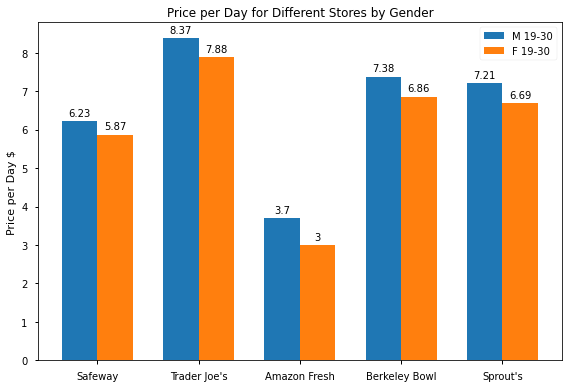

<Figure size 576x396 with 0 Axes>

In [34]:
#example of a saved png
cost_bar("19-30")
plt.savefig('bar.png')

### 2. Pie Chart Comparison of the Nutritional Contents across Stores

The `nutrition_pie` function takes the parameters and generates a pie graph showing percentages of different nutritions in descending order.

**Input Parameter:**

- **store**: a str with name of the store which is also the name of the individual sheet from the spreadsheet ("Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", or "Sprout's")
- **sex**: a str ("M" or "F"）
- **age**: a str ("4-8", "9-13", "14-18","19-30","31-50", or "51+")

In [35]:
def nutrition_pie(store, sex, age):
    group = f'{sex } {age}'
    FoodNutrients = match_n(store)
    Prices = match_p(store)
    tol=1e-6
    
    #cleaning data
    result = solve_subsistence_problem(store, FoodNutrients , Prices, diet_min[group], diet_max[group], tol=1e-6)
    diet = result.diet
    test = np.abs(result.A).dot(diet)
    a = pd.DataFrame(data = test)
    a = a.sort_values(0, ascending=False)
    x = a.values.tolist()
    #flatten 2D list
    import itertools
    x = list(itertools.chain.from_iterable(x))
    #round amount to the nearest integer
    x = np.array([int(n) for n in x])
    my_lables = a.index.tolist()
    myexplode = [0.1, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

    #creating pie chart
    colors = sns.color_palette("cubehelix_r", len(x))
    porcent = 100.*x/x.sum()
    patches, texts = plt.pie(x, colors= colors, startangle=90, shadow=True,  radius=1.2, explode =myexplode)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(my_lables, porcent)]

    
    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, x),
                                          key=lambda x: x[2],
                                          reverse=True))
    plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
    plt.title(f"Nutritional Content of a Vegetarian Diet, ({store}, {sex} {age})", bbox={'facecolor':'0.8', 'pad':5}, y=1.05)
    plt.show()

In [36]:
#interactive pie chart to explore differences across different stores, sex-age groups
interact(nutrition_pie,
         store = ["Safeway", "Trader Joe's", "Amazon Fresh", "Berkeley Bowl", "Sprout's"],
         sex = ["M","F"],
         age = ["4-8", "9-13", "14-18","19-30","31-50","51+"])

interactive(children=(Dropdown(description='store', options=('Safeway', "Trader Joe's", 'Amazon Fresh', 'Berke…

<function __main__.nutrition_pie(store, sex, age)>

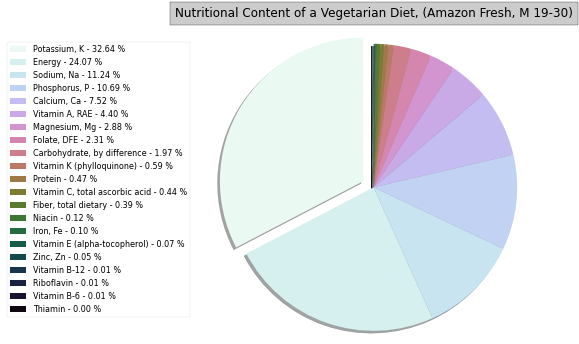

<Figure size 576x396 with 0 Axes>

In [37]:
#example of a saved png
nutrition_pie("Amazon Fresh", "M", "19-30")
plt.savefig('piechart.png')

## Response & Improvment after Code Review  <a name="res"></a>
Thank you all for the constructive feedback!

1. For Group Justus von Liebig:

    - Sorry about the API error, and unfortunately, it can't be solved on our end.
    - We have further clarified our goals in the description and more information can be found in our presentation and the slides. 
    - The sensitivity solution graph you mentioned is meant to be interactive, so it won't show in the PDF. We will demonstrate the function in the code run-through portion of our presentation. 
    - The nutrition pie chart also has an interactive function that allows the viewer to explore the differences across different age-gender groups which we will further explain in the presentation 
    

2. For Group Harriet Chick

    - It would definitely be very useful for the viewers to be able to see the units in the `necessary_nutrients()`  and `cheapest_diet()` functions. However, all the nutrients (macronutrients, minerals, and vitamins) have different units, and specifying each will increase the lengthiness of this function and future computation; instead of the exact intake of each nutrient, our target population might be more concerned with the unit of food they eventually need to consume which we have specified in the solution part. The `unit_convert` and `nutrient` functions already address the issue of the discrepancy of the units. If you want a detailed account of the units of all the nutrients, please refer to Appendix 1 in https://www.dietaryguidelines.gov/sites/default/files/2020-12/Dietary_Guidelines_for_Americans_2020-2025.pdf 
    - We will further address the delivery fee issue in our presentation. However, we felt this cost-minimized diet problem should only consider the direct cost (aka the food price) for all stores; although Amazon Fresh has a delivery fee, you can also consider how there would be potential transportation fees when commuting to the other stores. This indirect cost is definitely a factor of consideration, but we think it can only be thoroughly answered as a separate topic of exploration. The amazon delivery fee also could be zero or any price from $2-5 which is wholly dependent on the amount of food or other product that the consumer decides to purchase which is highly variable and hard to quantify since it's a personal preference. 
    - Our age bins are entirely based on the FDA's information and how they dissected the age groups. As we have specified, the "51+" bin actually does include older people.  
    - We felt pie charts are appropriate to represent the data because the nutritions add up to a meaningful whole that is approximately the same across different stores. Rather than stressing the exact quantity of nutritional consumption, pie charts here are meant to demonstrate the different nutritional emphasis of each diet, and they highlight the proportional differences (which we are going to further explain in the presentation) better than bar charts do. Based on your suggestion, we have created another function below that outputs a 2D pie chart with a ordered legend and some of the more trivial nutrients combined into the "Other" category. 

In [41]:
def nutrition_pie_other(store, sex, age):
    group = f'{sex } {age}'
    FoodNutrients = match_n(store)
    Prices = match_p(store)
    tol=1e-6
    
    #cleaning data
    result = solve_subsistence_problem(store, FoodNutrients , Prices, diet_min[group], diet_max[group], tol=1e-6)
    diet = result.diet
    test = np.abs(result.A).dot(diet)
    a = pd.DataFrame(data = test)
    a = a.sort_values(0, ascending=False)
    x = a.values.tolist()
    #flatten 2D list
    import itertools
    x = list(itertools.chain.from_iterable(x))
    #round amount to the nearest integer
    x = np.array([int(n) for n in x])
    x = np.append(x[:9], sum(x[9:]))

    my_lables = a.index.tolist()
    my_lables = my_lables[:9]+ ["Other Nutrients (each less than 1%)"]
    myexplode = [0.1, 0, 0, 0,0,0,0,0,0,0]

    #creating pie chart
    colors = sns.color_palette("cubehelix_r", len(x))
    porcent = 100.*x/x.sum()
    patches, texts = plt.pie(x, colors= colors, startangle=90, radius=1.2, explode =myexplode)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(my_lables, porcent)]

    
    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, x),
                                          key=lambda x: x[2],
                                          reverse=True))
    plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
    plt.title(f"Nutritional Content of a Vegetarian Diet, ({store}, {sex} {age})", bbox={'facecolor':'0.8', 'pad':5}, y=1.05)
    plt.show()

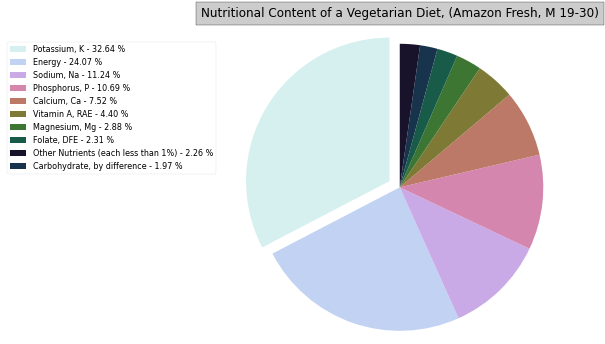

In [42]:
nutrition_pie_other("Amazon Fresh", "M", "19-30")
